In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/bootcamp/Averiguacao Cadastral/Dados

/content/drive/MyDrive/bootcamp/Averiguacao Cadastral/Dados


## Carregando as Bases de dados

In [3]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from numpy import mean, std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from matplotlib import pyplot
from catboost import CatBoostClassifier, Pool

## Preparação da base

In [9]:
# ABRINDO A BASE

pd.set_option('display.max_columns', 42)
pd.set_option('display.max_rows', 42)

#df = pd.read_csv('bases/df_modelo.csv', sep=',')
df = pd.read_csv('df_familia_pessoas_final.csv',nrows=100000)
df = df.sample(10000)
print(f'Shape:', df.shape)

Shape: (10000, 72)


In [10]:
df = df[['qtd_pessoas', 'meses_trabalho','idade','idoso',
                               'cod_principal_trab_memb', 'trabalho_principal','cod_deficiencia_memb','qtd_meses_12_meses_memb', 'dias_cadastramento',
                               'uf_ibge','classe_renda']]

<ipython-input-11-2953c318eaef>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='classe_renda', data=df, palette="coolwarm")


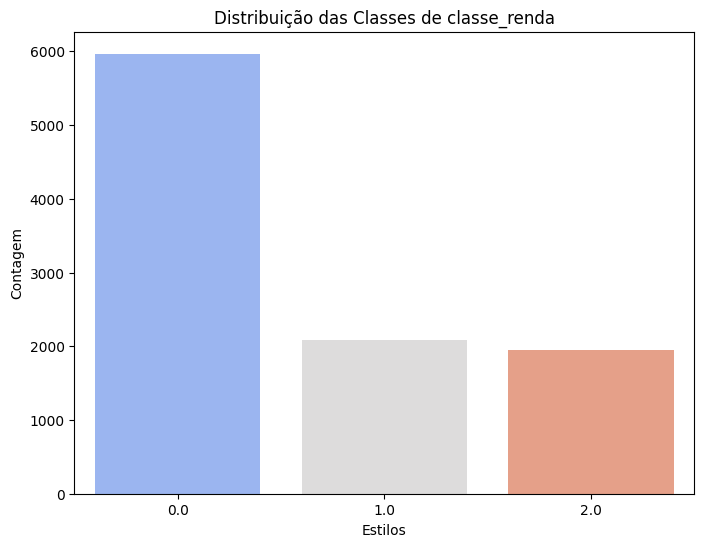

In [11]:
# visualizando distribuição da classe

# Contar a quantidade de cada categoria na variável 'Style'
plt.figure(figsize=(8, 6))
sns.countplot(x='classe_renda', data=df, palette="coolwarm")

# Adicionar título e rótulos
plt.title('Distribuição das Classes de classe_renda')
plt.xlabel('Estilos')
plt.ylabel('Contagem')

# Exibir o gráfico
plt.show()

>LogisticReg 0.712 (0.015)
>Knn 0.575 (0.012)
>DecisionTree 0.745 (0.012)
>SVM 0.597 (0.000)
>NaiveBayes 0.656 (0.014)
>RandomForest 0.749 (0.010)
>XGBoost 0.762 (0.010)
>CatBoostClassifier 0.762 (0.012)

Melhor modelo: XGBoost com acurácia média de 0.762


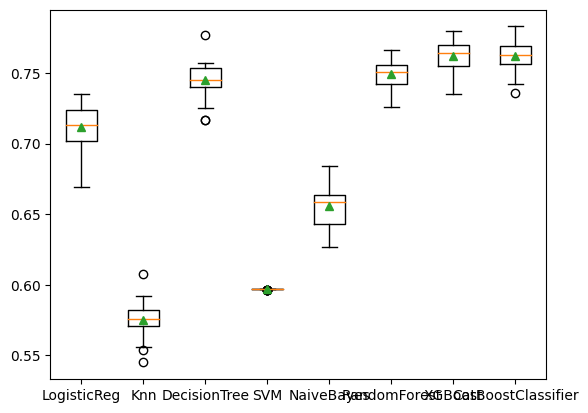

In [12]:
# estimando modelos

# get a list of models to evaluate
def get_models():
    models = dict()
    models['LogisticReg'] = LogisticRegression()
    models['Knn'] = KNeighborsClassifier()
    models['DecisionTree'] = DecisionTreeClassifier(max_depth=7, min_samples_split= 5)
    models['SVM'] = SVC()
    models['NaiveBayes'] = GaussianNB()
    models['RandomForest'] = RandomForestClassifier(max_depth=10, n_estimators= 100)
    models['XGBoost'] = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=300)
    models['CatBoostClassifier'] = CatBoostClassifier(depth=5, iterations=500, learning_rate =0.1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# define dataset
X = df.drop(columns=['classe_renda'])
y = df['classe_renda']

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# SEPARANDO VARIÁVEIS CATEGÓRICAS DE VARIÁVEIS NUMÉRICAS

categoricas = ['qtd_pessoas', 'meses_trabalho', 'cod_principal_trab_memb', 'idoso']
numericas = ['idade']

# NORMALIZANDO COLUNAS NUMÉRICAS

scaler = MinMaxScaler(feature_range=(0, 1))
X[numericas] = scaler.fit_transform(X[numericas])

# Codificando variáveis categóricas
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(X[categoricas])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categoricas))
X = pd.concat([X.drop(columns=categoricas), encoded_df], axis=1)



# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
best_score = 0
best_model = None

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    mean_score = mean(scores)
    print('>%s %.3f (%.3f)' % (name, mean_score, std(scores)))

    # Check if this is the best model so far
    if mean_score > best_score:
        best_score = mean_score
        best_model = name

# print the best model
print(f'\nMelhor modelo: {best_model} com acurácia média de {best_score:.3f}')

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>LogisticReg 0.649 (0.012)
>Knn 0.653 (0.011)
>DecisionTree 0.746 (0.011)
>SVM 0.597 (0.000)
>NaiveBayes 0.700 (0.011)
>RandomForest 0.744 (0.012)
>XGBoost 0.760 (0.009)
>CatBoostClassifier 0.763 (0.012)

Melhor modelo: CatBoostClassifier com acurácia média de 0.763


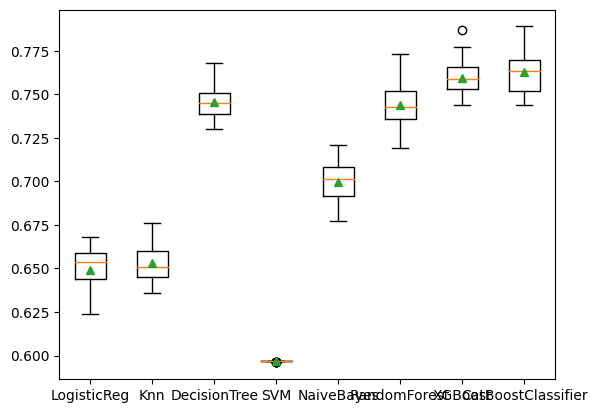

In [13]:
# estimando modelos

# get a list of models to evaluate
def get_models():
    models = dict()
    models['LogisticReg'] = LogisticRegression()
    models['Knn'] = KNeighborsClassifier()
    models['DecisionTree'] = DecisionTreeClassifier(max_depth=7, min_samples_split= 2)
    models['SVM'] = SVC()
    models['NaiveBayes'] = GaussianNB()
    models['RandomForest'] = RandomForestClassifier(max_depth=None, n_estimators= 200)
    models['XGBoost'] = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=300)
    models['CatBoostClassifier'] = CatBoostClassifier(depth=5, iterations=500, learning_rate =0.1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# define dataset
X = df.drop(columns=['classe_renda'])
y = df['classe_renda']

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
best_score = 0
best_model = None

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    mean_score = mean(scores)
    print('>%s %.3f (%.3f)' % (name, mean_score, std(scores)))

    # Check if this is the best model so far
    if mean_score > best_score:
        best_score = mean_score
        best_model = name

# print the best model
print(f'\nMelhor modelo: {best_model} com acurácia média de {best_score:.3f}')

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()